In [1]:
import torch
from transformers import CLIPTokenizer

/home/mlfavorfit/anaconda3/envs/diffusion/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.empty_cache()

## Device Check

In [3]:
DEVICE = "cpu"

ALLOW_CUDA = True
ALLOW_MPS = False

if torch.cuda.is_available() and ALLOW_CUDA:
    DEVICE = "cuda"

print(f"Using device: {DEVICE}")

Using device: cuda


## Load CLIP Tokenizer

In [4]:
tokenizer = CLIPTokenizer("./data/vocab.json", merges_file="./data/merges.txt")

In [ ]:
from Favorfit_image_to_text.clip_image_to_text import load_interrogator, inference

clip_model = load_interrogator("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/image_to_text/clip", caption_model_name="blip-base", device="cuda") 

## Useful function

In [5]:
from PIL import Image
import random

In [6]:
def convert_to_random_color_tiles(colors, weights, image_size=[512,512], tile_num_per_row=4):
    # 이미지 열기
    img = Image.new('RGB', image_size)

    # 이미지 크기 가져오기
    width, height = img.size
    tile_size = (512//tile_num_per_row, 512//tile_num_per_row)

    # 타일별로 이미지를 자르고 랜덤한 색상의 타일로 대체
    for y in range(0, height, tile_size[1]):
        for x in range(0, width, tile_size[0]):
            # 랜덤하게 색상 섞기
            seleted_color = random.choices(colors, weights, k=1)[0]

            # 랜덤한 타일 생성
            tile = Image.new('RGB', tile_size, tuple(seleted_color))

            # 원본 이미지에 랜덤한 타일 적용
            img.paste(tile, (x, y, x + tile_size[0], y + tile_size[1]))

    # 결과 이미지 저장 또는 표시
    # img.show()
    return img

In [7]:
def center_crop_and_resize(input_path, target_size=(512, 512)):
    # 이미지 열기
    image = Image.open(input_path).convert("RGB")

    # 이미지의 중앙을 기준으로 자르기
    width, height = image.size
    left = (width - min(width, height)) // 2
    top = (height - min(width, height)) // 2
    right = (width + min(width, height)) // 2
    bottom = (height + min(width, height)) // 2
    image = image.crop((left, top, right, bottom))

    # 리사이징
    image = image.resize(target_size)

    # 결과 저장
    return image

In [8]:
import numpy as np
def composing_output(generated_img, mask, original_img):
    generated_img = np.array(generated_img)
    mask = np.array(mask)
    original_img = np.array(original_img)

    composed_output = np.array(generated_img) * (1-mask/255) + np.array(original_img) * (mask/255)
    return Image.fromarray(composed_output.astype(np.uint8))

In [9]:
import cv2
def make_canny_condition(image, min=100, max=200):
    image = np.array(image)
    image = cv2.Canny(image, min, max)
    image = image[:, :, None]
    image = np.concatenate([image, image, image], axis=2)
    image = Image.fromarray(image)
    return image

In [10]:
from postprocess_remove_bg.rmbg_postprocess import MaskPostProcessor
mask_post_processor = MaskPostProcessor()

In [11]:
import cv2
def make_noise_disk(H, W, C, F):
    noise = np.random.uniform(low=0, high=1, size=((H // F) + 2, (W // F) + 2, C))
    noise = cv2.resize(noise, (W + 2 * F, H + 2 * F), interpolation=cv2.INTER_CUBIC)
    noise = noise[F: F + H, F: F + W]
    noise -= np.min(noise)
    noise /= np.max(noise)
    if C == 1:
        noise = noise[:, :, None]
    return noise

class ContentShuffleDetector:
    def __call__(self, img, h=None, w=None, f=None):
        img = np.array(img)
        H, W, C = img.shape
        if h is None:
            h = H
        if w is None:
            w = W
        if f is None:
            f = 256
        x = make_noise_disk(h, w, 1, f) * float(W - 1)
        y = make_noise_disk(h, w, 1, f) * float(H - 1)
        flow = np.concatenate([x, y], axis=2).astype(np.float32)
        return cv2.remap(img, flow, None, cv2.INTER_LINEAR)

In [12]:
csd = ContentShuffleDetector()

In [13]:
def make_background(image_size, color_rgb=[255,255,255], noise=0.1):
    w, h = image_size
    image_array = np.zeros((h, w, 3), dtype=np.uint8)
    image_array[:, :] = color_rgb

    # Add noise to the image
    noise_pixels = np.random.randint(0, 256, (h, w, 3))
    image_array = (1 - noise) * image_array + noise * noise_pixels
    image_array = np.clip(image_array, 0, 255).astype(np.uint8)

    image = Image.fromarray(image_array, 'RGB')
    return image

## Outpaint
---

In [14]:
def make_outpaint_condition(image, mask):
    image = np.array(image)
    mask = np.array(mask)
    black_image = np.zeros_like(image)

    composed_output = np.array(black_image) * (1-mask/255) + np.array(image) * (mask/255)
    return Image.fromarray(composed_output.astype(np.uint8))

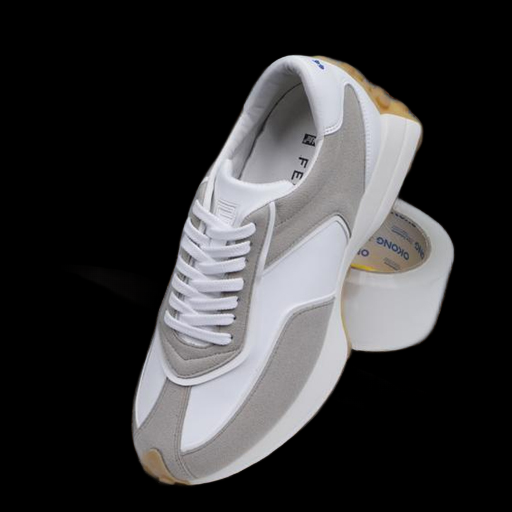

In [251]:
# image = center_crop_and_resize("./images/demo_image/kamil_512.jpg", target_size=[512,512])
image = center_crop_and_resize("/home/mlfavorfit/Downloads/sample/composition/1_comb.jpg", target_size=[512,512])

from Favorfit_remove_bg.inference import call_model, inference as mask_inference

remove_bg_model = call_model("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/remove_bg/remove_bg.pth", device="cuda")
mask_image = mask_inference(image, remove_bg_model)
reversed_mask = Image.fromarray(255 - np.array(mask_image.convert("L")))
control_image = make_outpaint_condition(image, mask_image)
control_image

In [324]:
caption = inference(img_pil=control_image, model=clip_model, mode="simple", remove_color=False)
caption

'pair of white grey sneakers'

- controlnet only

In [287]:
diffusion_state_dict = torch.load("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/diffusion/FavorfitArchitecture/favorfit_base.pth")
control_state_dict_outpaint = torch.load("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/diffusion/FavorfitArchitecture/controlnet/outpaint_v3.pth")
lora_state_dict = torch.load("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/diffusion/FavorfitArchitecture/lora/favorfit_lora.pth")


diffusion_state_dict["lora"] = lora_state_dict

In [288]:
from utils.model_loader import load_diffusion_model, load_controlnet_model

kwargs = {"is_lora":True}

models = load_diffusion_model(diffusion_state_dict, **kwargs)
controlnet = load_controlnet_model(control_state_dict_outpaint, is_inpaint_contorlnet=True)

models.update(controlnet)

In [289]:
control_image_png = Image.fromarray(np.concatenate([np.array(control_image), 255 - np.array(mask_image)[:,:,:1]], axis=2))

In [331]:
from pipelines.pipline_default_controlnet import generate

output_images = generate(
    prompt=f"product photo, official product, award winning, high resolution, 8k, {caption}",
    uncond_prompt="low quality, worst quality, wrinkled, deformed, distorted, jpeg artifacts,nsfw, paintings, sketches, text, watermark, username, spikey",
    input_image=image,
    control_image=[control_image_png],
    num_per_image=1,
    do_cfg=True,
    cfg_scale=12.5,
    sampler_name="ddpm",
    n_inference_steps=20,
    models=models,
    strength=1.0,
    seeds=-1,
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
    lora_scale=0.0,
    controlnet_scale=[1.0],
    control_image_scaling_range=(-1,1)
)

100%|██████████| 20/20 [00:03<00:00,  6.37it/s]


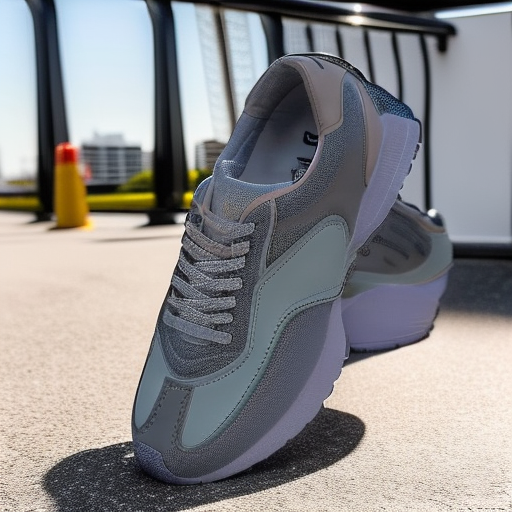

In [332]:
result_img = output_images[0]
result_img

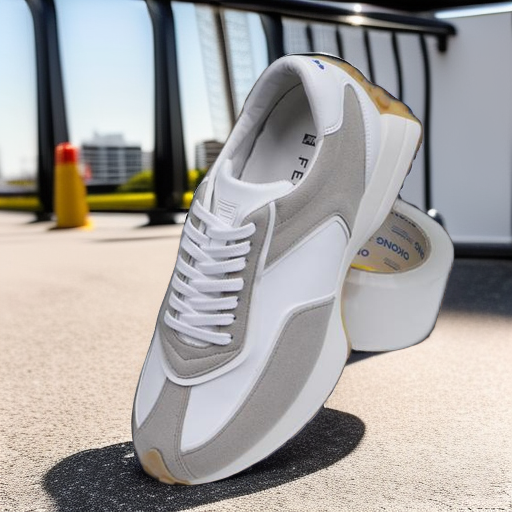

In [333]:
composed_img = composing_output(result_img, mask_image, image)
composed_img

- inpainting base

In [186]:
diffusion_state_dict = torch.load("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/diffusion/FavorfitArchitecture/favorfit_inpaint_ver1.2.pth")
control_state_dict = torch.load("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/diffusion/FavorfitArchitecture/controlnet/outpaint_v2.pth")
lora_state_dict = torch.load("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/diffusion/FavorfitArchitecture/lora/favorfit_lora.pth")

diffusion_state_dict["lora"] = lora_state_dict

In [187]:
from utils.model_loader import load_diffusion_model, load_controlnet_model

kwargs = {"is_lora":True, "is_inpaint":True}

models = load_diffusion_model(diffusion_state_dict, **kwargs)
controlnet = load_controlnet_model(control_state_dict)

models.update(controlnet)

In [224]:
from pipelines.pipeline_inpainting_controlnet import generate

output_images = generate(
    prompt=f"product photo, official product, {caption}, award winning, high resolution, 8k",
    uncond_prompt="low quality, worst quality, wrinkled, deformed, distorted, jpeg artifacts,nsfw, paintings, sketches, text, watermark, username, spikey",
    input_image=image,
    mask_image=reversed_mask,
    control_image=control_image,
    do_cfg=True,
    cfg_scale=10.5,
    sampler_name="ddpm",
    n_inference_steps=20,
    strength=1.0,
    models=models,
    seeds=[42],
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
    lora_scale=0.3,
)

100%|██████████| 20/20 [00:03<00:00,  6.31it/s]


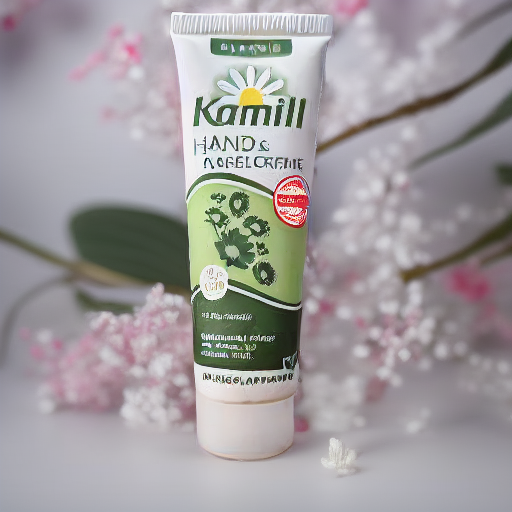

In [225]:
result_img = output_images[0]
result_img

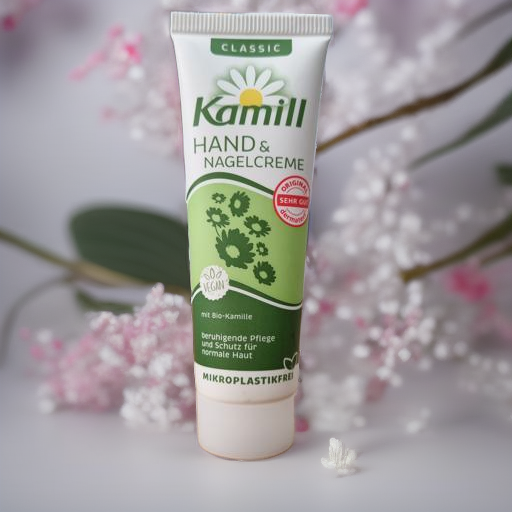

In [226]:
composed_img = composing_output(result_img, mask_image, image)
composed_img

- shuffle base

In [232]:
diffusion_state_dict = torch.load("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/diffusion/FavorfitArchitecture/favorfit_inpaint_ver1.2.pth")
control_state_dict_outpaint = torch.load("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/diffusion/FavorfitArchitecture/controlnet/outpaint_v2.pth")
control_state_dict_shuffle = torch.load("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/diffusion/FavorfitArchitecture/controlnet/shuffle.pth")
lora_state_dict = torch.load("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/diffusion/FavorfitArchitecture/lora/favorfit_lora.pth")


diffusion_state_dict["lora"] = lora_state_dict

In [233]:
from utils.model_loader import load_diffusion_model, load_controlnet_model

kwargs = {"is_lora":True, "is_inpaint":True}

models = load_diffusion_model(diffusion_state_dict, **kwargs)
controlnet = load_controlnet_model([control_state_dict_outpaint, control_state_dict_shuffle], apply_global_mean_pooling_per_models=[False, True])

models.update(controlnet)

In [234]:
import json

palette_list = []
with open("/media/mlfavorfit/sdb/palette_and_images/palette_data.jsonl", mode="r") as f:
    for cur in f:
        palette_list.append(json.loads(cur))

In [235]:
import numpy as np

image_list = []
color_list = []

for cur in palette_list:
    image_list.append(cur["image"])
    color_list.append(cur["colors"])

color_np = np.array(color_list).reshape(-1,12)

In [236]:
from Favorfit_recommend_template.inference import inference as color_recommend

In [237]:
def sorting_colors(colors):
    colors = sorted(colors, key=lambda x:x[2])
    colors = sorted(colors, key=lambda x:x[1])
    colors = sorted(colors, key=lambda x:x[0])
    return colors

In [238]:
from utils.color_utils import visualize_rgb_colors

In [239]:
recommended_colors = color_recommend(img_pil=image, mask_pil=mask_image)
similar_colors = np.array(sorting_colors(recommended_colors["similar_colors"]))
creative_colors = np.array(sorting_colors(recommended_colors["creative_colors"]))

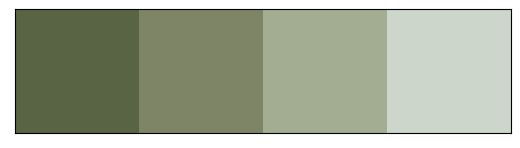

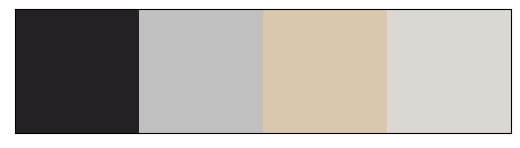

In [240]:
visualize_rgb_colors(similar_colors)
visualize_rgb_colors(creative_colors)

In [241]:
def cosine_similarity(target_color_np, color_np):
    similarities = []
    target_norm = np.linalg.norm(target_color_np) + 1
    
    for color in color_np:
        color_norm = np.linalg.norm(color) + 1
        similarity = np.dot(color, target_color_np) / (color_norm * target_norm)
        similarities.append(similarity)
    
    return np.array(similarities)

In [242]:
max_idx = np.argmax(cosine_similarity(similar_colors.reshape(12), color_np))
# max_idx = np.argmax(cosine_similarity(creative_colors.reshape(12), color_np))

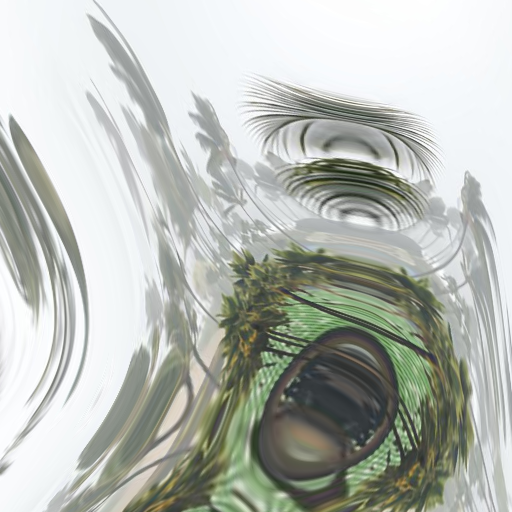

In [243]:
import os
from PIL import Image

root_dir = "/media/mlfavorfit/sdb/palette_and_images/image"
style_image = Image.open(os.path.join(root_dir, image_list[max_idx]))
shuffle_image = Image.fromarray(csd(np.array(style_image)))
shuffle_image

In [244]:
from pipelines.pipeline_inpainting_positive_controlnet import generate

output_images = generate(
    prompt=f"product photo, official product, {caption}, award winning, high resolution, 8k",
    uncond_prompt="low quality, worst quality, wrinkled, deformed, distorted, jpeg artifacts,nsfw, paintings, sketches, text, watermark, username, spikey",
    input_image=image,
    mask_image=reversed_mask,
    control_image=[control_image],
    positive_control_image=[shuffle_image],
    num_per_image=1,
    do_cfg=True,
    cfg_scale=10.5,
    sampler_name="ddpm",
    n_inference_steps=20,
    strength=1.0,
    models=models,
    seeds=[42],
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
    lora_scale=0.3,
    controlnet_scale=[1.0, 0.4]
)

100%|██████████| 20/20 [00:03<00:00,  5.72it/s]


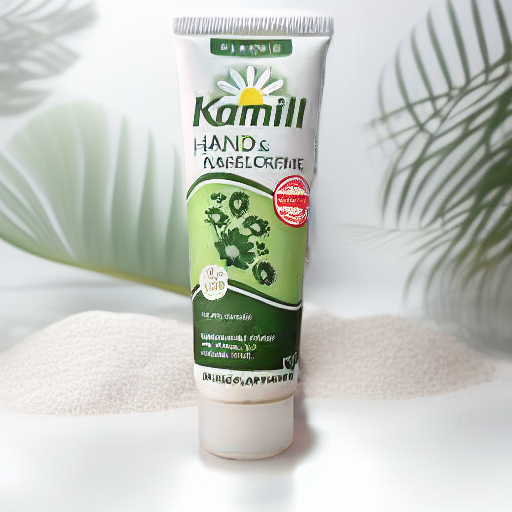

In [245]:
result_img = output_images[0]
result_img

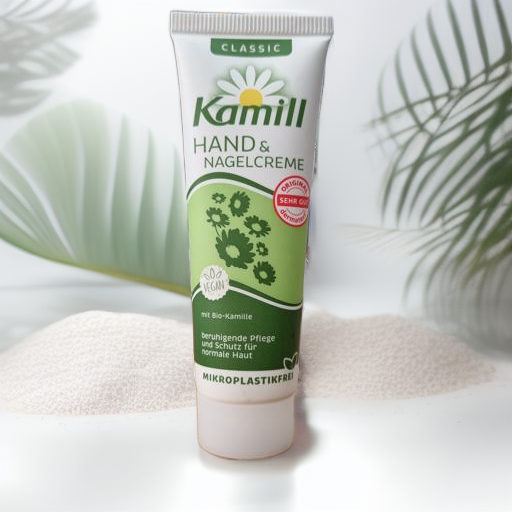

In [246]:
composed_img = composing_output(result_img, mask_image, image)
composed_img

## Composition

In [51]:
diffusion_state_dict = torch.load("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/diffusion/FavorfitArchitecture/favorfit_inpaint_ver1.2.pth")
control_state_dict = torch.load("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/diffusion/FavorfitArchitecture/controlnet/canny.pth")
lora_state_dict = torch.load("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/diffusion/FavorfitArchitecture/lora/favorfit_lora.pth")


diffusion_state_dict["lora"] = lora_state_dict

In [52]:
from utils.model_loader import load_diffusion_model, load_controlnet_model

kwargs = {"is_inpaint":True, "is_lora":True}

models = load_diffusion_model(diffusion_state_dict, **kwargs)
controlnet = load_controlnet_model(control_state_dict)

models.update(controlnet)

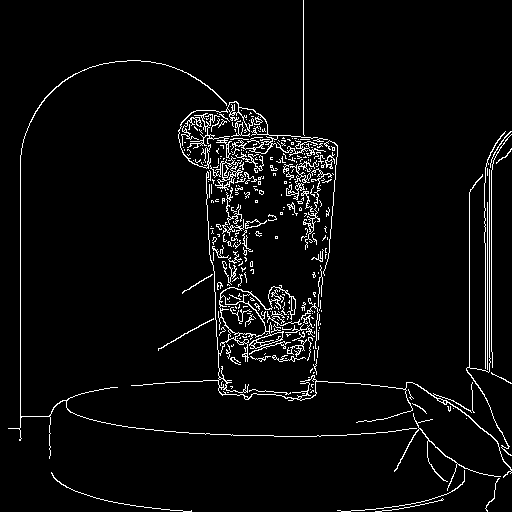

In [53]:
image = center_crop_and_resize("./images/demo_image/cocktail_template.png").convert("RGB")
control_image= make_canny_condition(image)
control_image

In [54]:
from Favorfit_remove_bg.inference import call_model, inference as mask_inference

remove_bg_model = call_model("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/remove_bg/remove_bg.pth", device="cuda")
mask = mask_inference(image, remove_bg_model)
reversed_mask = Image.fromarray(255 - np.array(mask.convert("L")))

In [55]:
from Favorfit_image_to_text.blip_image_to_text import load_interrogator, inference
interrogator = load_interrogator(model_path="/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/image_to_text/blip/blip_large.pth", device="cuda")
caption = inference(image, interrogator)
caption

'an alcoholic drink in a tall glass is ready to be enjoyed'

In [56]:
from pipelines.pipeline_inpainting_controlnet import generate

output_images = generate(
    prompt=f"product photo, official product, {caption}, award winning, high resolution, 8k",
    uncond_prompt="low quality, worst quality, wrinkled, deformed, distorted, jpeg artifacts,nsfw, paintings, sketches, text, watermark, username, spikey",
    input_image=image,
    mask_image=reversed_mask,
    control_image=control_image,
    num_per_image=1,
    do_cfg=True,
    cfg_scale=7.5,
    sampler_name="ddpm",
    n_inference_steps=20,
    strength=0.9,
    models=models,
    seeds=[42],
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
    lora_scale=0.7
)

100%|██████████| 18/18 [00:02<00:00,  6.42it/s]


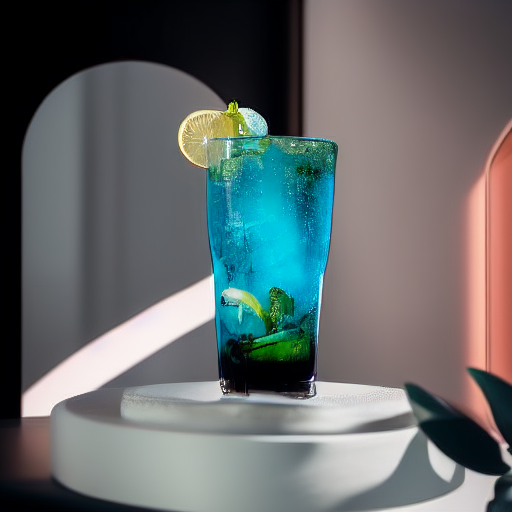

In [57]:
result_img = output_images[0]
result_img

## Augmentation

In [58]:
diffusion_state_dict = torch.load("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/diffusion/FavorfitArchitecture/favorfit_base.pth")
control_state_dict_shuffle = torch.load("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/diffusion/FavorfitArchitecture/controlnet/shuffle.pth")
control_state_dict_canny = torch.load("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/diffusion/FavorfitArchitecture/controlnet/canny.pth")
lora_state_dict = torch.load("/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/diffusion/FavorfitArchitecture/lora/favorfit_lora.pth")


diffusion_state_dict["lora"] = lora_state_dict

In [59]:
from utils.model_loader import load_diffusion_model, load_controlnet_model

kwargs = {"is_lora":True}

models = load_diffusion_model(diffusion_state_dict, **kwargs)
controlnet = load_controlnet_model([control_state_dict_canny, control_state_dict_shuffle], apply_global_mean_pooling_per_models=[False, True], **kwargs)
# controlnet = load_controlnet_model([control_state_dict_shuffle], apply_global_mean_pooling_per_models=[True], **kwargs)

models.update(controlnet)

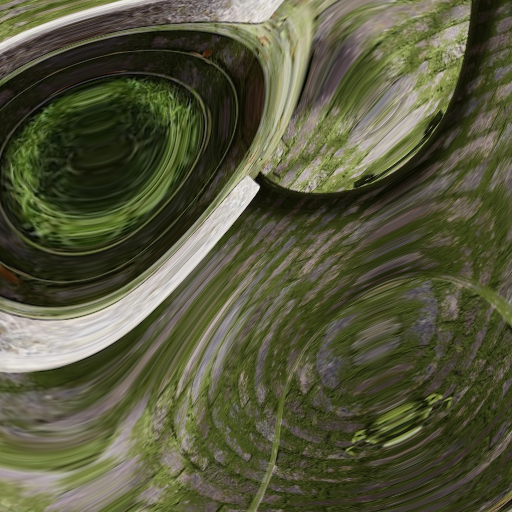

In [60]:
image = center_crop_and_resize("./images/test_image/template_base_2.jpg").convert("RGB")
style_image = center_crop_and_resize("./images/test_image/template_style.jpg").convert("RGB")
canny_image = make_canny_condition(image)
shuffle_image = Image.fromarray(csd(np.array(style_image)))
shuffle_image

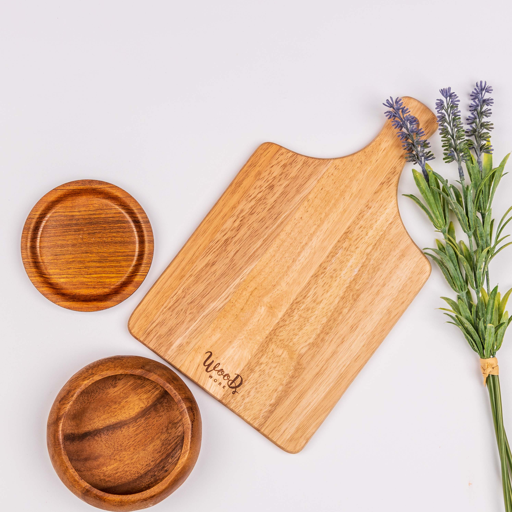

In [67]:
image

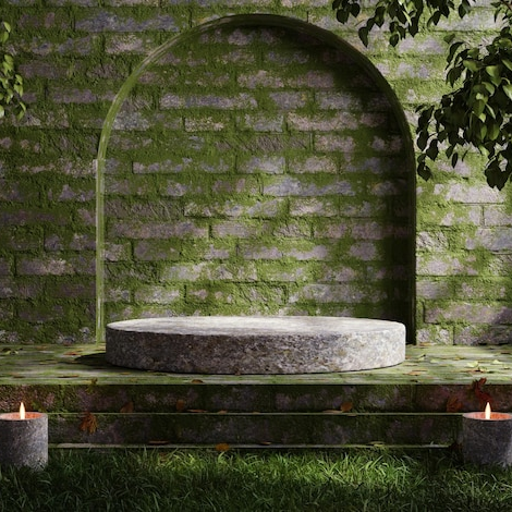

In [66]:
style_image

In [61]:
from Favorfit_image_to_text.blip_image_to_text import load_interrogator, inference
interrogator = load_interrogator(model_path="/home/mlfavorfit/lib/favorfit/kjg/0_model_weights/image_to_text/blip/blip_large.pth", device="cuda")
caption = inference(image, interrogator)
caption

'a wooden bowl, spoon, and chopping board laying on top of each other'

- global control

In [62]:
from pipelines.pipline_default_controlnet import generate

output_images = generate(
    prompt=f"professional photography, natural, {caption}, award winning, high resolution, 8k",
    uncond_prompt="low quality, worst quality, wrinkled, deformed, distorted, jpeg artifacts,nsfw, paintings, sketches, text, watermark, username, spikey",
    input_image=None,
    control_image=[canny_image, shuffle_image],
    num_per_image=1,
    do_cfg=True,
    cfg_scale=3.5,
    sampler_name="ddpm",
    n_inference_steps=20,
    strength=0.99,
    models=models,
    seeds=[42],
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
    lora_scale=0.7,
    controlnet_scale=[1.0,1.0]
)

100%|██████████| 20/20 [00:03<00:00,  5.38it/s]


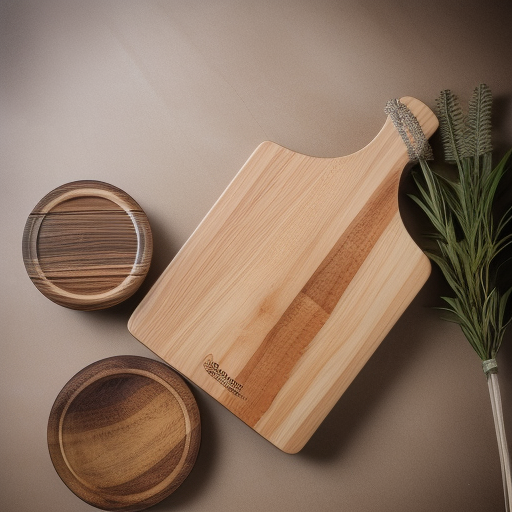

In [63]:
output_images[0]

- positive control

In [64]:
from pipelines.pipline_positive_controlnet import generate

output_images = generate(
    prompt=f"professional photography, natural, {caption}, award winning, high resolution, 8k",
    uncond_prompt="low quality, worst quality, wrinkled, deformed, distorted, jpeg artifacts,nsfw, paintings, sketches, text, watermark, username, spikey",
    input_image=None,
    control_image=[canny_image],
    positive_control_image=[shuffle_image],
    num_per_image=1,
    do_cfg=True,
    cfg_scale=7.5,
    sampler_name="ddpm",
    n_inference_steps=20,
    strength=0.99,
    models=models,
    seeds=[42],
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
    lora_scale=0.7,
    controlnet_scale=[1.0, 0.5]
)

100%|██████████| 20/20 [00:03<00:00,  5.70it/s]


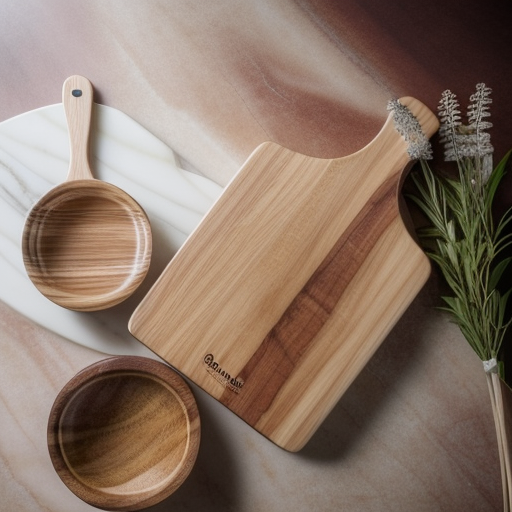

In [65]:
output_images[0]

In [44]:
img = Image.open("/home/mlfavorfit/Downloads/sample/composition/3_tp.jpg")

In [45]:
def resize_store_ratio(image, min_side=512):

    width, height = image.size

    if width < height:
        new_width = min_side
        new_height = int((height / width) * min_side)
    else:
        new_width = int((width / height) * min_side)
        new_height = min_side

    resized_image = image.resize((new_width, new_height), Image.ANTIALIAS)

    return resized_image


/tmp/ipykernel_90733/239575839.py:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = image.resize((new_width, new_height), Image.ANTIALIAS)


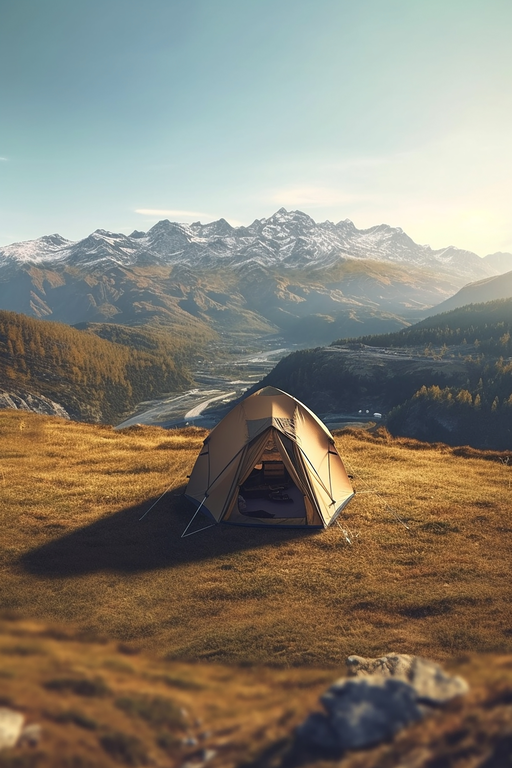

In [46]:
# new_img = resize_store_ratio(img.rotate(-90, expand=True))
new_img = resize_store_ratio(img)
new_img

In [47]:
new_img.save("/home/mlfavorfit/Downloads/sample/composition/3_tp.jpg")